In [1]:
import numpy as np                  # Librería para operar matrices y vectores
import matplotlib.pyplot as plt     # Librería para graficar figuras
from keras.datasets import cifar10   # Keras importa la base de datos MNIST
from keras.models import Sequential # Sequential sirve para declarar modelos neuronales
from keras.layers.core import Dense, Dropout, Activation, Flatten # Funciones para declarar capas neuronales específicas 
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils    # np_utils sirve para crear los vectores objetivo
from keras import optimizers
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint
import scipy.io as sio


Using TensorFlow backend.


Dimnesiones de X_train = (5000, 32, 32, 3)
Dimensiones de y_train = (5000, 1)


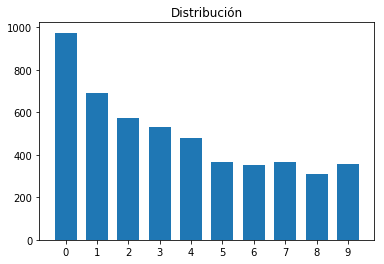

In [5]:
nb_classes = 10
# Base de datos SVHN: 73,257 ejemplos para entrenamiento y 26,032 ejemplos para verificación
data_train = sio.loadmat('svhn_train_32x32.mat')
X_train = np.transpose(data_train['X'], (3, 0, 1, 2))
y_train = data_train['y'] - 1

data_test= sio.loadmat('svhn_test_32x32.mat')
X_test = np.transpose(data_test['X'], (3, 0, 1, 2))
y_test = data_test['y'] - 1

X_train = X_train[0:5000,:,:,:]
y_train = y_train[0:5000,:]
X_test = X_test[0:100,:,:,:]
y_test = y_test[0:100,:]

print("Dimnesiones de X_train =", X_train.shape)
print("Dimensiones de y_train =", y_train.shape)
plt.hist(y_train, bins=np.arange(-0.5,10.5,1.0), rwidth=0.7) 
plt.title("Distribución")
plt.xticks(range(10))
plt.show()






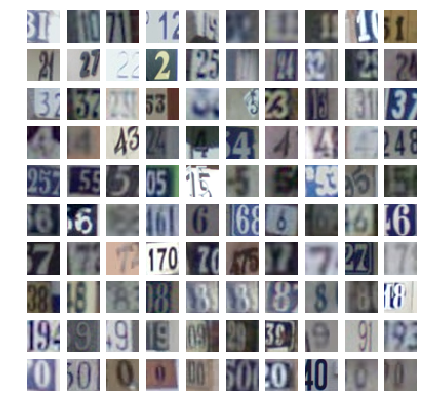

In [6]:
plt.rcParams['figure.figsize'] = (7,7) # Hacer las figuras más grandes

for i in range(10):
    index = np.where(y_train == i)
    index = index[0][np.random.randint(index[0].shape[0], size=10)]
    for j in range(10):
        plt.subplot(10,10,i*10+j+1)
        plt.imshow(X_train[index[j]], cmap='gray', interpolation='none')
        plt.axis('off')
#plt.savefig('shvn.pdf',bbox_inches='tight',dpi=300)
plt.show()


In [7]:
# Pre-Procesamiento
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Dimensiones de X_train =", X_train.shape)
print("Dimensiones de y_train =", X_test.shape)
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

Dimensiones de X_train = (5000, 32, 32, 3)
Dimensiones de y_train = (100, 32, 32, 3)


In [8]:
# Modelos 
learning_rate = 0.0001
nb_epochs = 100
mlp4 = Sequential()  #53% 
mlp4.add(Flatten(input_shape=X_train.shape[1:]))
mlp4.add(Dense(200, use_bias=True, activation='tanh'))                      
mlp4.add(Dense(100, use_bias=True, activation='tanh'))
mlp4.add(Dropout(0.5))
mlp4.add(Dense(20, use_bias=True, activation='tanh'))
mlp4.add(Dense(nb_classes, use_bias=True, activation='softmax'))
model = mlp4

In [9]:
learning_rate = 0.0001
nb_epochs = 40
cnn4_2 = Sequential()  #84% 
cnn4_2.add(Conv2D(32, (3, 3), activation='relu', use_bias=True, padding='same',input_shape=X_train.shape[1:]))
cnn4_2.add(Conv2D(32, (3, 3), activation='relu', use_bias=True))
cnn4_2.add(MaxPooling2D(pool_size=(2, 2)))
cnn4_2.add(Dropout(0.25))
cnn4_2.add(Conv2D(64, (3, 3), activation='relu', use_bias=True, padding='same'))
cnn4_2.add(Conv2D(64, (3, 3), activation='relu', use_bias=True))
cnn4_2.add(MaxPooling2D(pool_size=(2, 2)))
cnn4_2.add(Dropout(0.25))
cnn4_2.add(Flatten())
cnn4_2.add(Dense(512, activation='relu', use_bias=True))
cnn4_2.add(Dropout(0.5))
cnn4_2.add(Dense(nb_classes, use_bias=True, activation='softmax'))
model = cnn4_2

In [10]:
learning_rate = 0.0001
nb_epochs = 30
cnn6_3 = Sequential()  #79% 
cnn6_3.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], activation='relu', padding='same'))
cnn6_3.add(Dropout(0.2))
cnn6_3.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
cnn6_3.add(MaxPooling2D(pool_size=(2, 2)))
cnn6_3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn6_3.add(Dropout(0.2))
cnn6_3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn6_3.add(MaxPooling2D(pool_size=(2, 2)))
cnn6_3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn6_3.add(Dropout(0.2))
cnn6_3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn6_3.add(MaxPooling2D(pool_size=(2, 2)))
cnn6_3.add(Flatten())
cnn6_3.add(Dropout(0.2))
cnn6_3.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
cnn6_3.add(Dropout(0.2))
cnn6_3.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
cnn6_3.add(Dropout(0.2))
cnn6_3.add(Dense(nb_classes, activation='softmax'))
model = cnn6_3

In [12]:
# Entrenamiento
adam = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="bestmodel_svhn.h5", monitor='val_acc', verbose=0, save_best_only=True, mode='max', period=1)
h = model.fit(X_train, Y_train, batch_size=128, epochs=nb_epochs , verbose=1, validation_data=(X_test, Y_test), shuffle=True, callbacks=[checkpointer])



Train on 5000 samples, validate on 100 samples
Epoch 1/30
5000/5000 [==============================] - 18s - loss: 2.1907 - acc: 0.2070 - val_loss: 2.1613 - val_acc: 0.2900

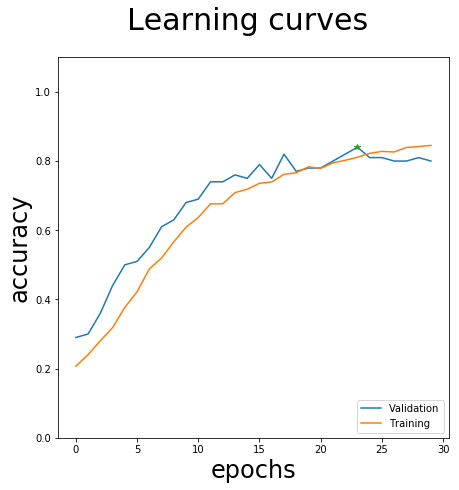

In [13]:
epoch_max = np.argmax(h.history['val_acc'])
plt.plot(h.history['val_acc'], label='Validation')
plt.plot(h.history['acc'], label='Training')
plt.legend(loc='lower right')
plt.plot(epoch_max, h.history['val_acc'][epoch_max],'*')
plt.xlabel('epochs', fontsize=24)
plt.ylabel('accuracy', fontsize=24)
plt.suptitle('Learning curves', fontsize=30)
axes = plt.gca()
axes.set_ylim([0,1.1])

#plt.savefig('accuracyVSunits/00ALTaccVSepochs.pdf', bbox_inches='tight')
plt.show()



In [14]:
# Evaluar el mejor modelo
model.load_weights("bestmodel_svhn.h5")
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.703564224243
Test accuracy: 0.84


 96/100 [===========================>..] - ETA: 0s

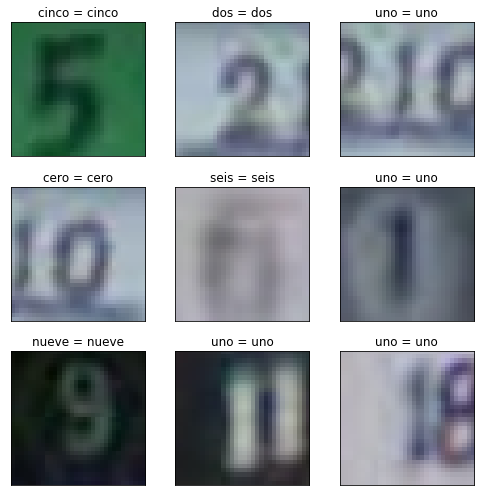

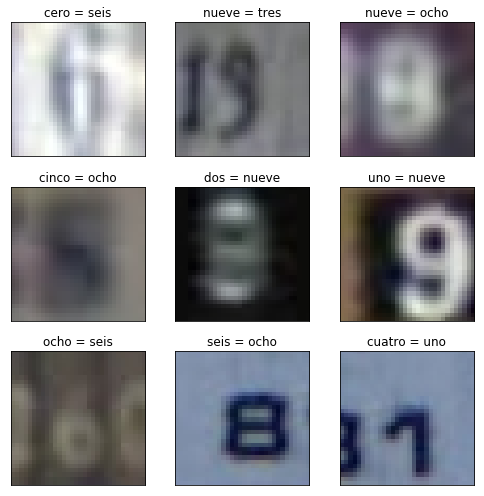

In [15]:
# Inspección visual de los errores
# Modificar este codigo
predicted_classes = model.predict_classes(X_test)
correct_indices = np.nonzero(predicted_classes == np.squeeze(y_test))[0]
incorrect_indices = np.nonzero(predicted_classes != np.squeeze(y_test))[0]

objects = ['uno','dos','tres','cuatro','cinco','seis','siete','ocho','nueve','cero']


plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(32,32,3), interpolation='none')
    plt.title(objects[predicted_classes[correct]] + ' = ' + objects[y_test[correct][0]])
    plt.tick_params(axis='both',which='both',bottom='off',left='off',labelbottom='off',labelleft='off') 
plt.tight_layout()
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(32,32,3), interpolation='none')
    plt.title(objects[predicted_classes[incorrect]] + ' = ' + objects[y_test[incorrect][0]])
    plt.tick_params(axis='both',which='both',bottom='off',left='off',labelbottom='off',labelleft='off') 
plt.tight_layout()
plt.show()


Normalized confusion matrix
[[ 0.92592593  0.          0.          0.03703704  0.          0.
   0.03703704  0.          0.          0.        ]
 [ 0.07692308  0.92307692  0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.85714286  0.          0.          0.          0.
   0.          0.14285714  0.        ]
 [ 0.          0.          0.          0.91666667  0.          0.08333333
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.875       0.          0.
   0.          0.125       0.        ]
 [ 0.          0.          0.          0.          0.          0.8         0.
   0.1         0.          0.1       ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.16666667  0.          0.          0.16666667  0.16666667
   0.          0.16666667  0.33333333  0.        ]
 [ 0.14285714  0.142

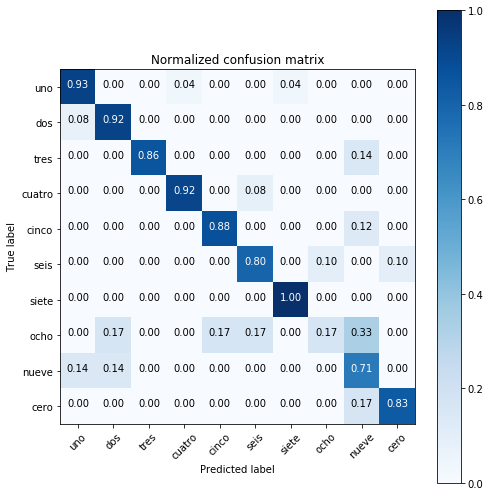

In [16]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """ This function prints and plots the confusion matrix. """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

import itertools
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, predicted_classes)
plot_confusion_matrix(cnf_matrix, classes=objects, normalize=True, title='Normalized confusion matrix')

plt.show()